In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from math import sqrt

In [ ]:
LTI_data=pd.read_csv('LTI.BO.csv');LTI_data


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-08-23,4921.549805,5104.000000,4921.549805,5055.850098,5007.199219,29455
1,2021-08-24,5062.000000,5142.049805,4963.299805,4981.049805,4933.118652,21755
2,2021-08-25,5030.000000,5134.000000,4961.649902,5090.049805,5041.069824,13801
3,2021-08-26,5105.000000,5219.450195,5052.950195,5131.299805,5081.922363,32752
4,2021-08-27,5169.899902,5250.000000,5100.000000,5237.500000,5187.101074,18659
...,...,...,...,...,...,...,...
243,2022-08-12,5000.000000,5007.100098,4895.250000,4911.649902,4911.649902,16968
244,2022-08-16,4970.000000,4976.700195,4880.100098,4886.350098,4886.350098,14007
245,2022-08-17,4905.000000,4999.000000,4894.000000,4963.500000,4963.500000,13893
246,2022-08-18,4920.000000,4935.950195,4852.200195,4922.950195,4922.950195,16372


In [ ]:
LTI_data['Date'] = pd.to_datetime(LTI_data['Date'], format='%Y-%m-%d')
LTI_data = LTI_data.sort_values(by='Date',ascending=True)
LTI_data['Date'] = LTI_data['Date'].dt.strftime('%d-%m-%Y') 
LTI_data.set_index('Date',drop=True,inplace=True) 
LTI_data.head(15)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
23-08-2021,4921.549805,5104.000000,4921.549805,5055.850098,5007.199219,29455
24-08-2021,5062.000000,5142.049805,4963.299805,4981.049805,4933.118652,21755
25-08-2021,5030.000000,5134.000000,4961.649902,5090.049805,5041.069824,13801
26-08-2021,5105.000000,5219.450195,5052.950195,5131.299805,5081.922363,32752
27-08-2021,5169.899902,5250.000000,5100.000000,5237.500000,5187.101074,18659
30-08-2021,5261.000000,5324.450195,5234.000000,5265.299805,5214.633301,18978
31-08-2021,5271.049805,5373.850098,5260.000000,5313.100098,5261.973633,106458
01-09-2021,5350.000000,5388.299805,5271.000000,5280.350098,5229.539063,14384
02-09-2021,5320.000000,5429.950195,5265.350098,5383.149902,5331.349121,9591


In [ ]:
data = LTI_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1); data

,Close
Date,
23-08-2021,5055.850098
24-08-2021,4981.049805
25-08-2021,5090.049805
26-08-2021,5131.299805
27-08-2021,5237.500000
...,...
12-08-2022,4911.649902
16-08-2022,4886.350098
17-08-2022,4963.500000


In [ ]:
date = list(LTI_data.index)

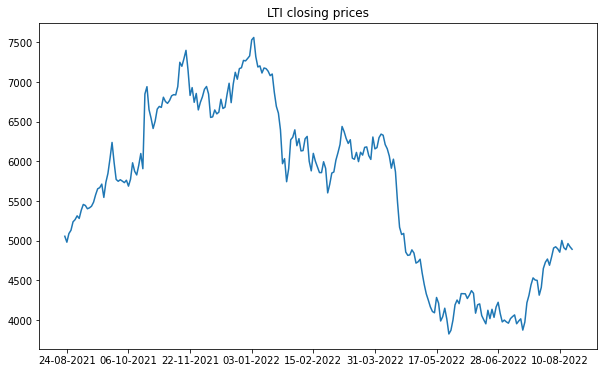

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(data)
index = np.arange(1,248,30)
plt.xticks(index, labels = date[1:248:30])
plt.title('LTI closing prices')
plt.show()

In [ ]:
def load_data(stock, look_back):
    data_raw = stock # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.25*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    date_train = date[10:train_set_size+10]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    date_test = date[train_set_size+10:-1]
    #return [x_train, y_train, x_test, y_test]
    return [x_train, y_train, date_train, x_test, y_test, date_test]

In [ ]:
sc = MinMaxScaler()
data = sc.fit_transform(data)

x_train, y_train, date_train, x_test, y_test, date_test = load_data(data, 11)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('date_train length = ', len(date_train))
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)
print('date_test length = ', len(date_test))

x_train.shape =  (178, 10, 1)
y_train.shape =  (178, 1)
date_train length =  178
x_test.shape =  (59, 10, 1)
y_test.shape =  (59, 1)
date_test length =  59


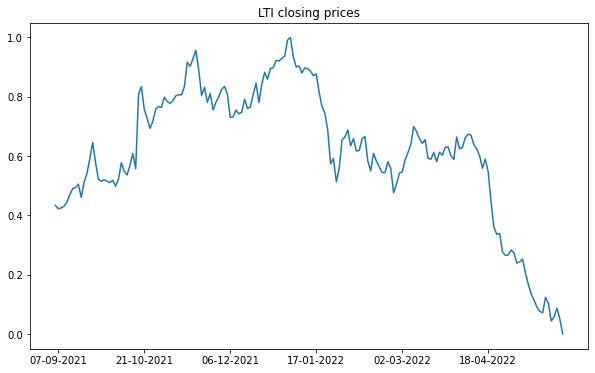

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(y_train)
index = np.arange(1,178,30)
plt.xticks(index, labels = date_train[1:178:30])
plt.title('LTI closing prices')
plt.show()

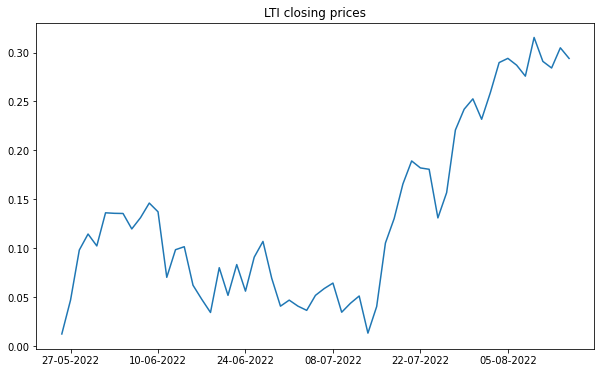

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(y_test)
index = np.arange(1,59,10)
plt.xticks(index, labels = date_test[1:59:10])
plt.title('LTI closing prices')
plt.show()

In [ ]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
# Build model
#####################
input_dim = 1
hidden_dim = 10
num_layers = 4 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 10, num_layers=4, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
18
torch.Size([40, 1])
torch.Size([40, 10])
torch.Size([40])
torch.Size([40])
torch.Size([40, 10])
torch.Size([40, 10])
torch.Size([40])
torch.Size([40])
torch.Size([40, 10])
torch.Size([40, 10])
torch.Size([40])
torch.Size([40])
torch.Size([40, 10])
torch.Size([40, 10])
torch.Size([40])
torch.Size([40])
torch.Size([1, 10])
torch.Size([1])


In [ ]:
sum(i.numel() for i in model.parameters())

3171

In [ ]:
num_epochs = 550
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =10


for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.05110827460885048
Epoch  20 MSE:  0.05109351873397827
Epoch  30 MSE:  0.05050859600305557
Epoch  40 MSE:  0.04876658692955971
Epoch  50 MSE:  0.04222472757101059
Epoch  60 MSE:  0.02643156610429287
Epoch  70 MSE:  0.025064127519726753
Epoch  80 MSE:  0.019978687167167664
Epoch  90 MSE:  0.011460374109447002
Epoch  100 MSE:  0.008523037657141685
Epoch  110 MSE:  0.00595443369820714
Epoch  120 MSE:  0.004984067752957344
Epoch  130 MSE:  0.0047414773143827915
Epoch  140 MSE:  0.004288095515221357
Epoch  150 MSE:  0.004079353995621204
Epoch  160 MSE:  0.0038402769714593887
Epoch  170 MSE:  0.0035742323379963636
Epoch  180 MSE:  0.0033056132961064577
Epoch  190 MSE:  0.003021766897290945
Epoch  200 MSE:  0.0027382406406104565
Epoch  210 MSE:  0.0024863616563379765
Epoch  220 MSE:  0.0023215075489133596
Epoch  230 MSE:  0.004137788433581591
Epoch  240 MSE:  0.0026148257311433554
Epoch  250 MSE:  0.002139451913535595
Epoch  260 MSE:  0.0019928207620978355
Epoch  270 MSE:  0.

In [ ]:
# make predictions
y_test_pred = model(x_test)
y_train_pred = model(x_train)



# invert predictions
y_train_pred = sc.inverse_transform(y_train_pred.data.numpy())
y_train = sc.inverse_transform(y_train.data.numpy())
y_test_pred = sc.inverse_transform(y_test_pred.data.numpy())
y_test = sc.inverse_transform(y_test.data.numpy())

# calculate root mean squared error
trainScore = sqrt(mse(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mse(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 154.10 RMSE
Test Score: 174.30 RMSE


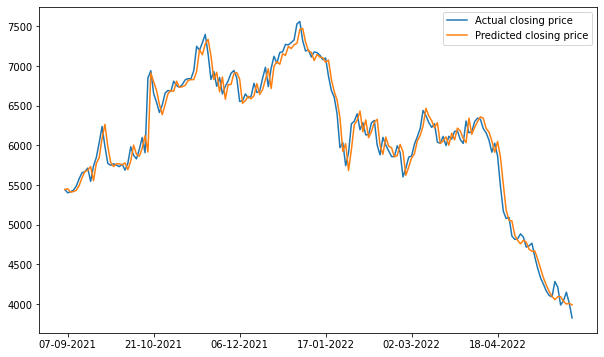

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(y_train, label = 'Actual closing price')
plt.plot(y_train_pred, label = 'Predicted closing price')
index = np.arange(1,178,30)

plt.xticks(index, labels = date_train[1:178:30])
plt.legend()
plt.show()

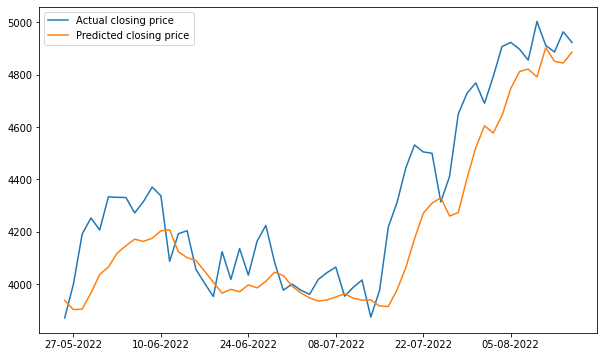

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(y_test, label = 'Actual closing price')
plt.plot(y_test_pred, label = 'Predicted closing price')
index = np.arange(1,59,10)
plt.xticks(index, labels = date_test[1:59:10])
plt.legend()
plt.show()